In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib.image as image
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Loading the Directories

In [2]:
test_dir = "../input/fruits/fruits-360/Test"
train_dir = "../input/fruits/fruits-360/Training"

# Organizing files into dataframes

In [3]:
train_df = pd.DataFrame(columns = ["item_id","item_category"])
for item in os.listdir(train_dir):
    path = train_dir +"/"+  item
    for item_id in os.listdir(path):
        train_df = train_df.append({"item_id":item_id,"item_category":item},ignore_index = True)
train_df.head()

,item_id,item_category
0,r_305_100.jpg,Quince
1,139_100.jpg,Quince
2,128_100.jpg,Quince
3,r_239_100.jpg,Quince
4,185_100.jpg,Quince


In [4]:
test_df = pd.DataFrame(columns = ["item_id","item_category"])
for item in os.listdir(test_dir):
    path = test_dir +"/"+  item
    for item_id in os.listdir(path):
        test_df = test_df.append({"item_id":item_id,"item_category":item},ignore_index = True)
test_df.head()

,item_id,item_category
0,r_168_100.jpg,Quince
1,18_100.jpg,Quince
2,30_100.jpg,Quince
3,302_100.jpg,Quince
4,311_100.jpg,Quince


# Data Distribution

<AxesSubplot:xlabel='count', ylabel='item_category'>

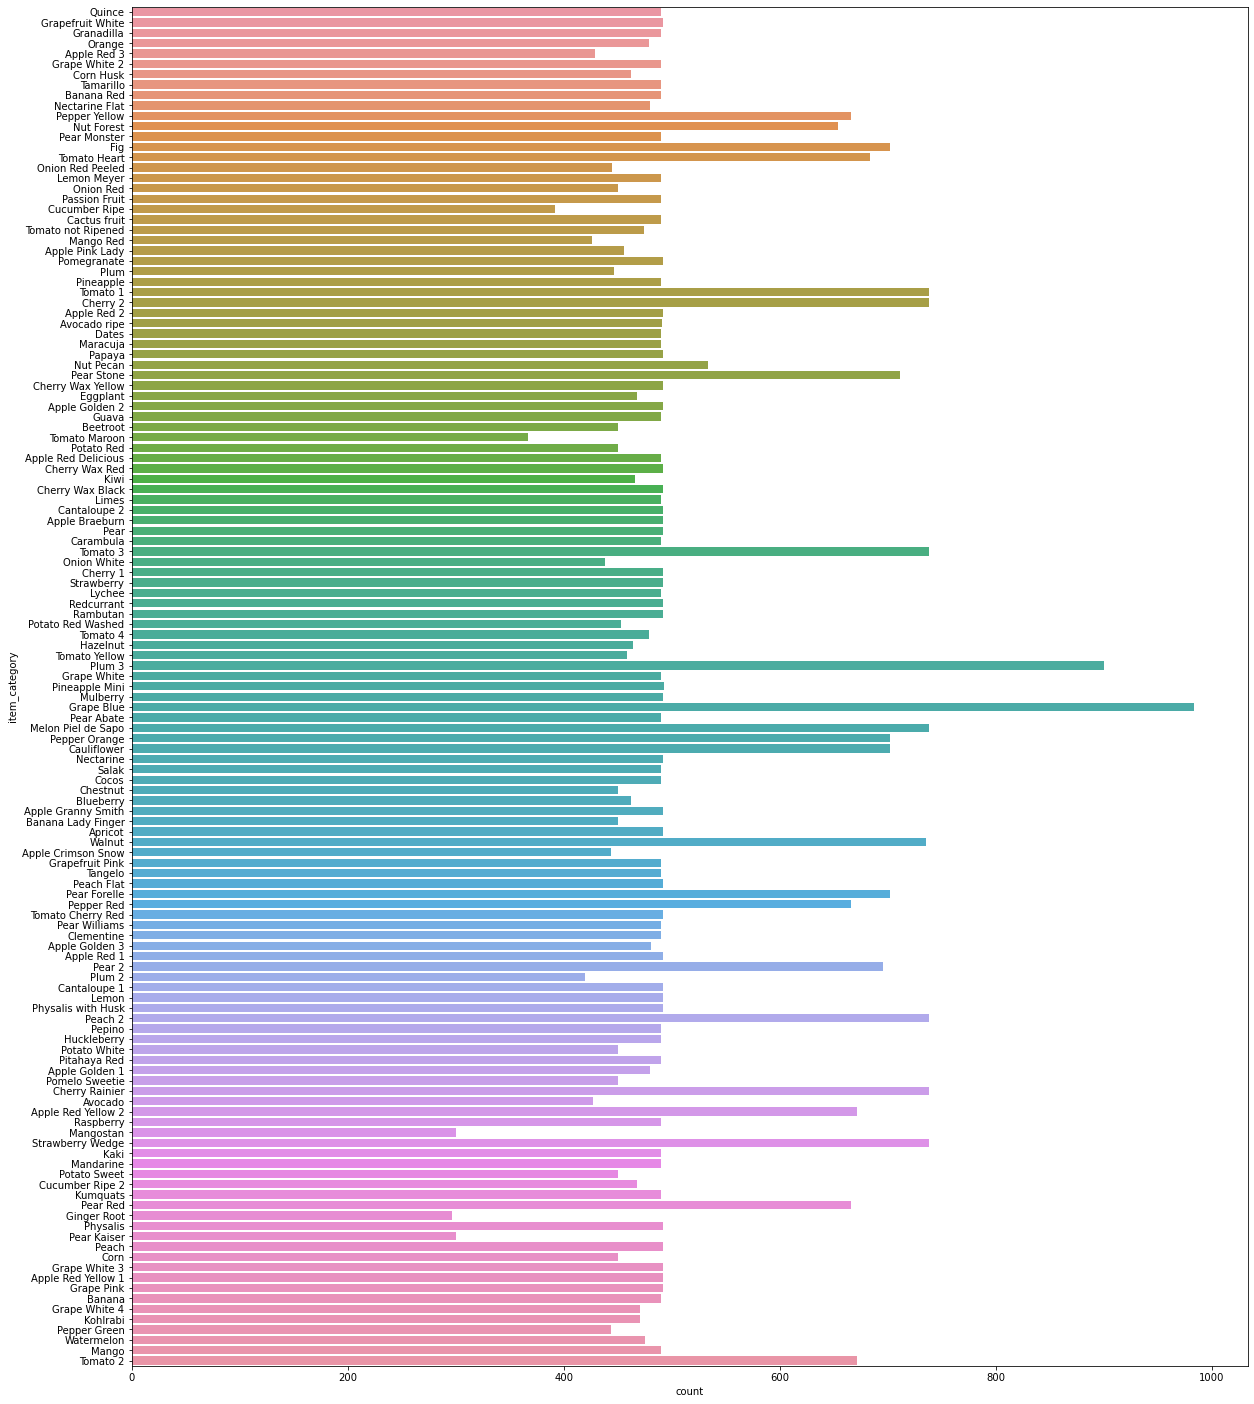

In [5]:
plt.figure(figsize=(20,25))
sns.countplot(data = train_df,y = "item_category")

# Processing Data

In [6]:
train_datagen = ImageDataGenerator(rescale=1./255,horizontal_flip=True,validation_split = 0.2)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
      directory = train_dir,
      subset="training",
      target_size = (100,100),
      shuffle = True,
      class_mode = 'categorical',
      batch_size=500)
    
val_gen = train_datagen.flow_from_directory(
      directory = train_dir,
      subset="validation",
      shuffle = True,
      class_mode = 'categorical',
      target_size=(100,100),
      batch_size=500)
test_gen = test_datagen.flow_from_directory(
      directory = test_dir,
      shuffle = True,
      class_mode = 'categorical',
      target_size = (100,100),
      batch_size = 500)

Found 54190 images belonging to 131 classes.
Found 13502 images belonging to 131 classes.
Found 22688 images belonging to 131 classes.


# Model

## Making the Model

In [7]:
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Dropout,BatchNormalization
from tensorflow.keras.applications import VGG16

In [8]:
base_model = VGG16(include_top=False,weights='imagenet',input_shape=(100,100,3))
base_model.trainable = False
print("Length of Model: ",len(list((base_model.layers))))
gal1 = GlobalAveragePooling2D()(base_model.output)
d1 = Dense(units = 512,activation = "relu")(gal1)
drop1 = Dropout(0.2)(d1)
d2 = Dense(units = 256,activation = "relu")(drop1)
drop2 = Dropout(0.2)(d2)
bn = BatchNormalization()(drop2)
output = Dense(units = 131,activation = "softmax")(bn)
model = Model(inputs = base_model.input, outputs = output)
model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.001),loss="categorical_crossentropy",metrics=["categorical_accuracy"])
model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Length of Model:  19
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 100, 100, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 100, 100, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 50, 50, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 50, 50, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 50, 50, 128)       147584    
_________________________________________

## Training

In [9]:
history = model.fit(train_gen,validation_data = val_gen,batch_size = 500,steps_per_epoch = 54190 // 500,epochs = 5)

Epoch 1/5
108/108 [==============================] - 325s 3s/step - loss: 3.4195 - categorical_accuracy: 0.3011 - val_loss: 3.3873 - val_categorical_accuracy: 0.9316
Epoch 2/5
108/108 [==============================] - 78s 720ms/step - loss: 0.3974 - categorical_accuracy: 0.9370 - val_loss: 2.0977 - val_categorical_accuracy: 0.9613
Epoch 3/5
108/108 [==============================] - 80s 738ms/step - loss: 0.1331 - categorical_accuracy: 0.9805 - val_loss: 0.8625 - val_categorical_accuracy: 0.9669
Epoch 4/5
108/108 [==============================] - 78s 723ms/step - loss: 0.0672 - categorical_accuracy: 0.9922 - val_loss: 0.2350 - val_categorical_accuracy: 0.9716
Epoch 5/5
108/108 [==============================] - 78s 720ms/step - loss: 0.0447 - categorical_accuracy: 0.9939 - val_loss: 0.1073 - val_categorical_accuracy: 0.9779


## Model History

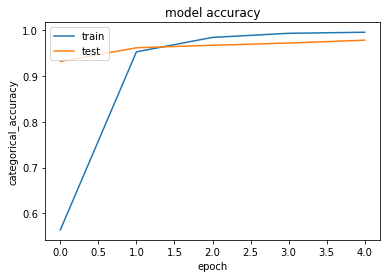

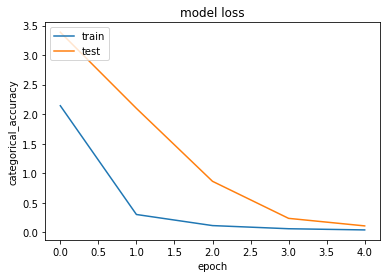

In [10]:
def plot_history(history):
    # summarize history for accuracy
    plt.plot(history.history['categorical_accuracy'])
    plt.plot(history.history['val_categorical_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('categorical_accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('categorical_accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
plot_history(history)

## Model Evaluation

In [11]:
model.evaluate(test_gen)

46/46 [==============================] - 107s 2s/step - loss: 0.2177 - categorical_accuracy: 0.9500


[0.21766285598278046, 0.9499735832214355]

## Working with the model

In [12]:
classes = list(train_gen.class_indices)

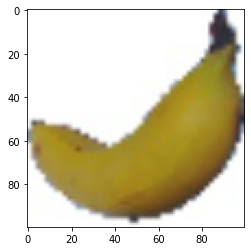

In [13]:
x = plt.imread("../input/fruits/fruits-360/Training/Banana/0_100.jpg")
plt.imshow(x)

In [14]:
x = x/255
x = np.resize(x,(131,100,100,3))
x.shape
print(classes[np.argmax(model.predict(x))])

Banana


In [15]:
pred_album = pd.DataFrame(columns = ["item_id","prediction"])
for item in os.listdir("../input/fruits/fruits-360/test-multiple_fruits"):
    x = plt.imread("../input/fruits/fruits-360/test-multiple_fruits" + "/" + item)
    x = np.resize(x,(131,100,100,3))
    pred_album = pred_album.append({"item_id":item,"prediction":classes[np.argmax(model.predict(x)[0])]},ignore_index = True)
pred_album.to_csv("predictions.csv")